![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 6.2. Poisson Regression Model with Offset (Rate Data)

In many real-world scenarios, we’re interested not just in the count of occurrences of an event but also in the rate at which the event occurs over a specific exposure period (e.g., the number of road accidents per mile or cases of a disease per population over a set timeframe). This type of data is often called "rate data" and is particularly well-suited to Poisson regression with an offset. An offset variable allows us to account for the varying exposure times or population sizes in our data, making it possible to model the rate of events rather than simply the count.

This tutorial will dive into Poisson regression with an offset, which is essential when analyzing rate data. We’ll start with a model overview, discussing the purpose and assumptions of Poisson regression with an offset term. We’ll then move on to fitting the model both from scratch (to gain insights into how it works) and with R’s convenient glm() function. Following this, we’ll examine model diagnosis techniques to ensure the model fits the data well, discuss model evaluation methods, and conclude with the interpretation of incidence rate ratios (IRRs), which help quantify the predictors' effect on the rate outcome.

## Overview

**Poisson regression** is commonly used to model **rates** instead of simple **counts** in practical applications. For example, if you want to model the rate of events happening over time, space, or another unit of exposure (such as the number of accidents per mile driven or the number of diseases per population), you need to consider the varying levels of exposure across different observations. This is where the concept of an **offset** comes into play. An **offset** is a known quantity (the exposure) that adjusts the model to accurately represent the rate of event occurrence.

***What is an Offset?***

- The **offset** in Poisson regression represents the **logarithm** of the exposure variable. The exposure variable is the denominator in the rate calculation (e.g., time, population, or space).
- The offset allows us to model the number of events **per unit of exposure**, rather than just raw counts.



The standard Poisson regression model for counts is:

$$ \log(\lambda_i) = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} $$

Where:

- $\lambda_i$ is the expected count for the $i^{th}$ observation.
- $X_{1i}, X_{2i}, \dots, X_{pi}$ are the predictor variables.
- $beta_0, \beta_1, \dots, \beta_p$ are the regression coefficients.

In the **Poisson regression with offset**, we modify the model to incorporate the exposure variable $e_i$. The offset term is the **log** of the exposure, ensuring that the response variable is modeled as a **rate** rather than a simple count.

The model becomes:

$$ log(\lambda_i) = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} + \log(e_i) $$

Or equivalently:

$$ lambda_i = e_i \exp(\beta_0 + \beta_1 X_{1i} + \dots + \beta_p X_{pi}) $$

Where:

- $e_i$ is the exposure (e.g., time, population size, or area).
- $\lambda_i$ is now the expected **rate of events** per unit of exposure.
- $\log(e_i)$ is added as a known term (the offset) and is not estimated as part of the model.

**Why Use an Offset?**

The offset is critical when:
1. **Exposure varies across observations**: In many datasets, each observation may have a different level of exposure (e.g., different time periods, population sizes, or geographic areas). The offset adjusts for these differences.
2. **Modeling rates**: Poisson regression with an offset models rates (e.g., the number of events per unit of exposure) rather than raw counts.

Without the offset, the model would incorrectly treat counts as if all observations had the same exposure.



## Poisson Model with an  offset

Below is the Python code for fitting a Poisson model with an offset and four predictors from scratch. The code follows the same structure: generating data, defining the Poisson log-likelihood function, optimizing parameters, creating a summary statistics table, and checking for overdispersion. I’ve used NumPy, SciPy, and Pandas for computations and data handling

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm, poisson

### Create a Data

For this example, we’ll simulate some count data, including four predictors and an offset variable.


In [2]:
# Set random seed for reproducibility
np.random.seed(123)

# --- Create Data ---
n = 100  # Sample size

# Generate predictors
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
x3 = np.random.normal(size=n)
x4 = np.random.normal(size=n)
offset = np.log(1 + np.random.normal(loc=5, scale=1, size=n))  # Offset term

# Generate response variable y using a true model with coefficients
beta = np.array([0.5, 0.3, -0.2, 0.4, 0.1])
lambda_ = np.exp(beta[0] + beta[1] * x1 + beta[2] * x2 + beta[3] * x3 + beta[4] * x4 + offset)
y = np.random.poisson(lambda_)

# Combine into a DataFrame
data = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'offset': offset})
print("First few rows of data:\n", data.head())


First few rows of data:
     y        x1        x2        x3        x4    offset
0  17 -1.085631  0.642055  0.703310  0.765055  2.019438
1  13  0.997345 -1.977888 -0.598105 -0.828989  1.699294
2  25  0.282978  0.712265  2.200702 -0.659151  1.706388
3   4 -1.506295  2.598304  0.688297  0.611124  1.545611
4   9 -0.578600 -0.024626 -0.006307 -0.144013  1.790315


### Specify the Poisson Model with Offset

The Poisson regression model with an offset can be specified as follows:

$$ \log(\lambda) = \beta_0 + \beta_1 \cdot x1 + \beta_2 \cdot x2 + \beta_3 \cdot x3 + \beta_4 \cdot x4 + \text{offset} $$

Defined using Python syntax, with `poisson.logpmf` for the Poisson log-likelihood. The function returns the negative log-likelihood for minimization, consistent with R’s approach.

In [6]:
# Log-likelihood function for Poisson regression with offset
def poisson_log_likelihood_offset(params):
    beta0, beta1, beta2, beta3, beta4 = params
    lambda_ = np.exp(beta0 + beta1 * data['x1'] + beta2 * data['x2'] + 
                     beta3 * data['x3'] + beta4 * data['x4'] + data['offset'])
    log_likelihood = np.sum(poisson.logpmf(data['y'], lambda_))
    return -log_likelihood  # Negative for minimization

### Optimize the Parameters

We minimize with the `BFGS` method (a robust optimization algorithm) instead of R’s `optim`. The `Hessian inverse` is accessed via `result.hess_inv` for standard errors.

In [7]:
# Initial guesses for beta coefficients
initial_params = np.zeros(5)

# Use minimize to find MLEs for the coefficients
result = minimize(poisson_log_likelihood_offset, initial_params, method='BFGS', options={'disp': True})

# Extract parameter estimates
coefficients = result.x

# Compute standard errors from the inverse Hessian
std_errors = np.sqrt(np.diag(result.hess_inv))  # Access hess_inv from result

Optimization terminated successfully.
         Current function value: 245.811493
         Iterations: 15
         Function evaluations: 156
         Gradient evaluations: 26


### Create a Summary Statistics Table

To summarize the results, let’s calculate the Z-scores and p-values for each coefficient.


In [8]:
# Calculate Z-scores and p-values
z_scores = coefficients / std_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Create summary table
summary_table = pd.DataFrame({
    'Coefficient': coefficients,
    'Std_Error': std_errors,
    'Z_value': z_scores,
    'P_value': p_values
}, index=['Intercept', 'x1', 'x2', 'x3', 'x4'])

# Display summary table
print("\nSummary Table:\n", summary_table)


Summary Table:
            Coefficient  Std_Error    Z_value       P_value
Intercept     0.465674   0.035227  13.219184  0.000000e+00
x1            0.282614   0.028379   9.958453  0.000000e+00
x2           -0.198248   0.031369  -6.319842  2.618317e-10
x3            0.422390   0.030817  13.706365  0.000000e+00
x4            0.026768   0.035165   0.761211  4.465309e-01


###  Check for Overdispersion

To check for overdispersion, calculate the dispersion statistic, which is the ratio of the residual deviance to the degrees of freedom.


In [9]:
# Calculate fitted values
lambda_hat = np.exp(coefficients[0] + coefficients[1] * data['x1'] + 
                    coefficients[2] * data['x2'] + coefficients[3] * data['x3'] + 
                    coefficients[4] * data['x4'] + data['offset'])

# Calculate Pearson residuals
pearson_residuals = (data['y'] - lambda_hat) / np.sqrt(lambda_hat)

# Calculate dispersion statistic
dispersion_statistic = np.sum(pearson_residuals**2) / (n - len(coefficients))

# Display dispersion statistic
print("\nDispersion Statistic:", dispersion_statistic)

# Check for overdispersion
if dispersion_statistic > 1.2:
    print("Warning: Evidence of overdispersion")
else:
    print("No evidence of overdispersion")


Dispersion Statistic: 0.9221450889869148
No evidence of overdispersion


## Poisson Model with Python 


Below is the Python code, which performs data loading, preprocessing, descriptive statistics, visualization, Poisson regression modeling, and model diagnostics. The code uses Python libraries such as `pandas`, `numpy`, `matplotlib`, `seaborn`, `statsmodels` and some other relevents libraries. 


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import poisson
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(11076)

### Data

The County-level age-adjusted number and rate of diabetes patients, prevalence of obesity, physical inactivity and [Food environment index](https://www.ers.usda.gov/data-products/food-environment-atlas.aspx) for the year 2016-2020 were obtained from United States [Diabetes Surveillance System (USDSS)](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html).

![alt text](http://drive.google.com/uc?export=view&id=1pNL0FF71fPQqfSffEMjHuIdGdiZdYVDs)

Full data set is available for download from my [Dropbox](https://www.dropbox.com/scl/fi/ynrinqzj58f3x5mvc96as/county_data_2016_2020.csv?rlkey=zpy7qxrh6r4l01ct4hjxgcnds&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.



Dataset contains five years average (2016-2020) of following variables :

1.  `Diabetes_count` -  Diabetes number per county ([Diabetes Surveillance System (USDSS))](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html)

2.  `Diabetes_per` - Diabetes number per county [(Diabetes Surveillance System (USDSS))](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html)

3. `Urban_Rural` - Urban Rural County (USDA)

4. `PPO_total` - Total population per  county (US Census)

5. `Obesity` - % obesity per county [(Behavioral Risk Factor Surveillance System)](https://www.cdc.gov/brfss/)  

6. `Physical_Inactivity`: % adult access to exercise opportunities ([County Health Ranking](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation))

7. `SVI` - Level of social vulnerability in the county relative to other counties in the nation or within the state.ocial vulnerability refers to the potential negative effects on communities caused by external stresses on human health. The CDC/ATSDR Social vulnerability Index (SVI) ranks all US counties on 15 social factors, including poverty, lack of vehicle access, and crowded housing, and groups them into four related themes. ( [CDC/ATSDR Social Vulnerability Index (SVI)](https://www.atsdr.cdc.gov/placeandhealth/svi/interactive_map.html))

8. `Food_Env_Index`: Measure of access to healthy food. The Food Environment Index ranges from a scale of 0 (worst) to 10 (best) and equally weights two indicators: 1) Limited access to healthy foods based on distance an individual lives from a grocery store or supermarket, locations for healthy food purchases in most communities; and 2) Food insecurity defined as the inability to access healthy food because of cost barriers.[County Health Ranking](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation)

In [12]:
# Load data
url = "https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/county_data_2016_2020.csv"
mf = pd.read_csv(url)

# Select variables
df = mf[['Diabetes_per', 'POP_Total', 'Obesity', 'Physical_Inactivity', 
         'Access_Excercise', 'Food_Env_Index', 'SVI', 'Urban_Rural']].copy()

# Data processing
df['Diabetes_per'] = df['Diabetes_per'].astype(int)
df['Urban_Rural'] = df['Urban_Rural'].astype('category')

# Display data summary (similar to glimpse())
print("\nData Summary:")
print(df.info())


Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Diabetes_per         3107 non-null   int64   
 1   POP_Total            3107 non-null   float64 
 2   Obesity              3107 non-null   float64 
 3   Physical_Inactivity  3107 non-null   float64 
 4   Access_Excercise     3107 non-null   float64 
 5   Food_Env_Index       3107 non-null   float64 
 6   SVI                  3107 non-null   float64 
 7   Urban_Rural          3107 non-null   category
dtypes: category(1), float64(6), int64(1)
memory usage: 173.2 KB
None


### Data Description



In [13]:
print("\nDescriptive Statistics (Codebook):")
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        print(f"\n{col}:")
        print(f"  Mean: {df[col].mean():.2f}")
        print(f"  Median: {df[col].median():.2f}")
        print(f"  Min: {df[col].min():.2f}")
        print(f"  Max: {df[col].max():.2f}")
        print(f"  SD: {df[col].std():.2f}")
    else:
        print(f"\n{col}:")
        print(df[col].value_counts())


Descriptive Statistics (Codebook):

Diabetes_per:
  Mean: 8.10
  Median: 8.00
  Min: 3.00
  Max: 16.00
  SD: 1.60

POP_Total:
  Mean: 104466.38
  Median: 26060.00
  Min: 149.80
  Max: 10077818.60
  SD: 334048.05

Obesity:
  Mean: 27.59
  Median: 27.86
  Min: 12.06
  Max: 42.12
  SD: 4.80

Physical_Inactivity:
  Mean: 21.16
  Median: 20.84
  Min: 9.64
  Max: 36.72
  SD: 4.30

Access_Excercise:
  Mean: 61.98
  Median: 64.00
  Min: 0.00
  Max: 100.00
  SD: 21.78

Food_Env_Index:
  Mean: 7.32
  Median: 7.50
  Min: 1.60
  Max: 10.00
  SD: 1.09

SVI:
  Mean: 0.50
  Median: 0.50
  Min: 0.00
  Max: 1.00
  SD: 0.29

Urban_Rural:
Urban_Rural
Urban    1797
Rural    1310
Name: count, dtype: int64


#### Density Plot

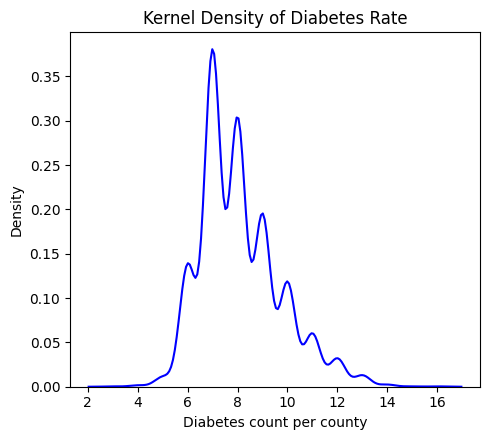

In [14]:
# --- Density Plot ---
plt.figure(figsize=(5, 4.5))
sns.kdeplot(data=df, x='Diabetes_per', color='blue')
plt.xlabel("Diabetes count per county")
plt.ylabel("Density")
plt.title("Kernel Density of Diabetes Rate")
plt.tight_layout()
plt.show()

#### Descriptive Statistics

In [15]:
# --- Descriptive Statistics by Urban_Rural ---
# Standard error function
def se(x):
    return np.std(x, ddof=1) / np.sqrt(len(x))

# Summary statistics by Urban_Rural
summarise_diabetes = df.groupby('Urban_Rural').agg({
    'Diabetes_per': [
        ('Mean', lambda x: round(x.mean(), 2)),
        ('Median', lambda x: round(x.median(), 2)),
        ('Min', lambda x: round(x.min(), 2)),
        ('Max', lambda x: round(x.max(), 2)),
        ('SD', lambda x: round(x.std(), 2)),
        ('SE', lambda x: round(se(x), 3))
    ]
}).reset_index()
summarise_diabetes.columns = ['Urban_Rural', 'Mean', 'Median', 'Min', 'Max', 'SD', 'SE']
print("\nSummary Statistics by Urban_Rural:")
print(summarise_diabetes)


Summary Statistics by Urban_Rural:
  Urban_Rural  Mean  Median  Min  Max    SD     SE
0       Rural  7.75     7.0    4   16  1.53  0.042
1       Urban  8.35     8.0    3   15  1.61  0.038


#### Boxplot - Urban vs Rural

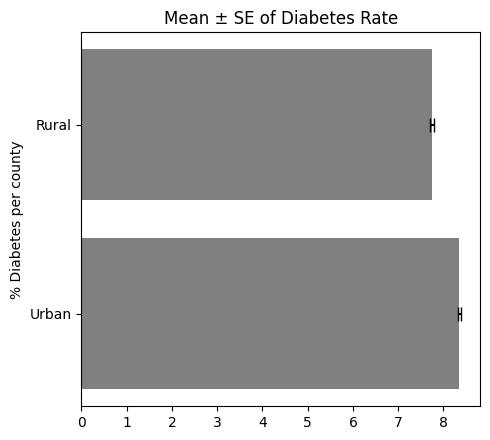

In [16]:
# --- Barplot: Mean ± SE of Diabetes Rate ---
plt.figure(figsize=(5, 4.5))
barplot = sns.barplot(data=summarise_diabetes, x='Mean', y='Urban_Rural', color='gray')
plt.errorbar(y=summarise_diabetes.index, x=summarise_diabetes['Mean'], 
             xerr=summarise_diabetes['SE'], fmt='none', c='black', capsize=5)
plt.xlabel("")
plt.ylabel("% Diabetes per county")
plt.title("Mean ± SE of Diabetes Rate")
plt.tight_layout()
plt.show()


#### Correlation Plot

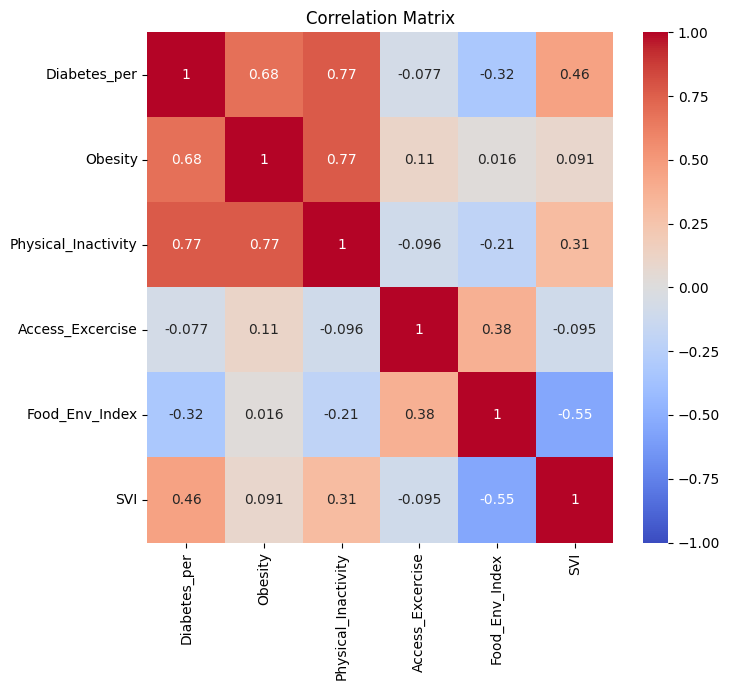

In [17]:
corr_vars = ['Diabetes_per', 'Obesity', 'Physical_Inactivity', 
             'Access_Excercise', 'Food_Env_Index', 'SVI']
corr_matrix = df[corr_vars].corr()
plt.figure(figsize=(7.5, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Let explore correlation in rural and urban counties:

<Figure size 750x700 with 0 Axes>

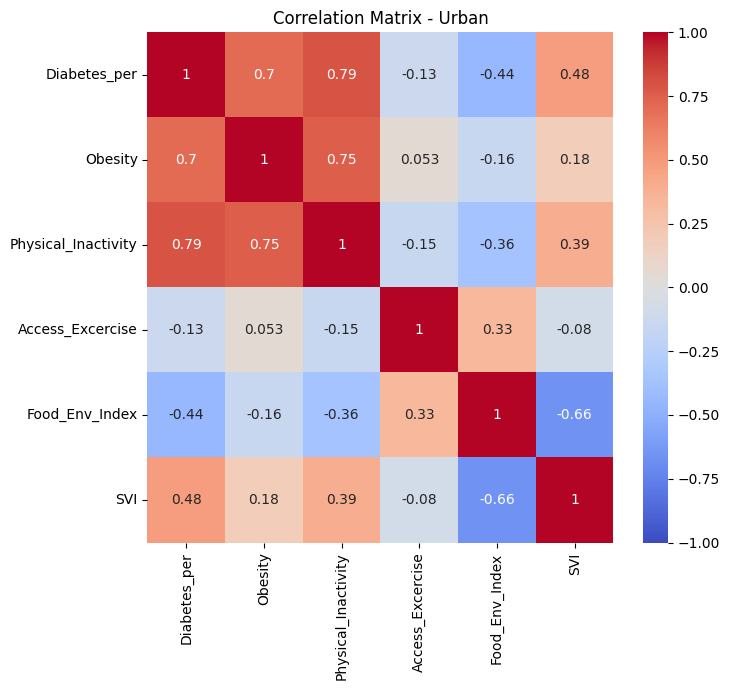

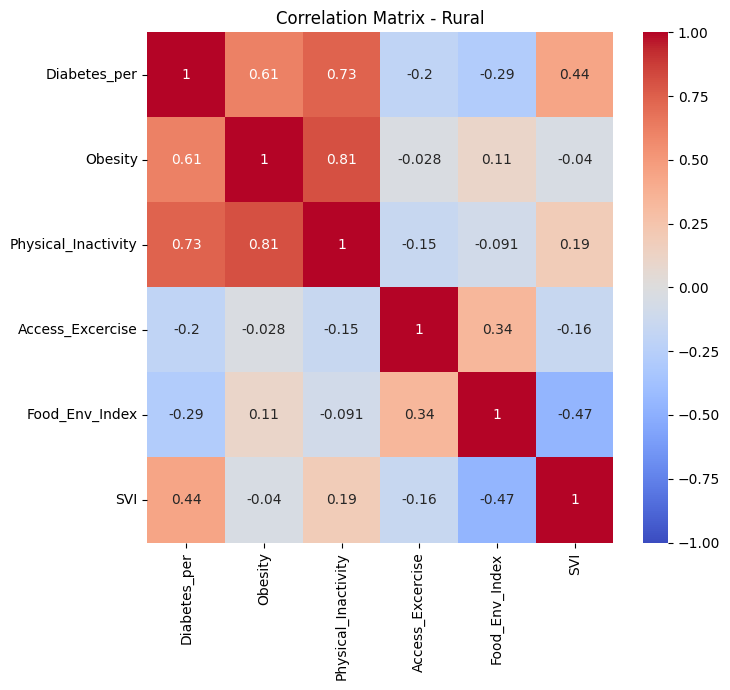

In [18]:
# --- Correlation Plot by Urban_Rural ---
plt.figure(figsize=(7.5, 7))
for group in df['Urban_Rural'].unique():
    corr_matrix = df[df['Urban_Rural'] == group][corr_vars].corr()
    plt.figure(figsize=(7.5, 7))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix - {group}")
    plt.tight_layout()
    plt.show()

### Split Data

We will split data into homogeneous subgroups using **stratified random sampling**. This method involves dividing the population into strata and taking random samples from each stratum to ensure that each subgroup is proportionally represented in the sample. The goal is to obtain a representative sample of the population by adequately representing each stratum.

In [19]:
df['log_POP_Total'] = np.log(df['POP_Total'])
tr_prop = 0.70

# Stratified random sampling
train = df.groupby('Urban_Rural').apply(
    lambda x: x.sample(frac=tr_prop, random_state=101)
).reset_index(drop=True)
test = df.groupby('Urban_Rural').apply(
    lambda x: x.drop(x.sample(frac=tr_prop, random_state=101).index)
).reset_index(drop=True)

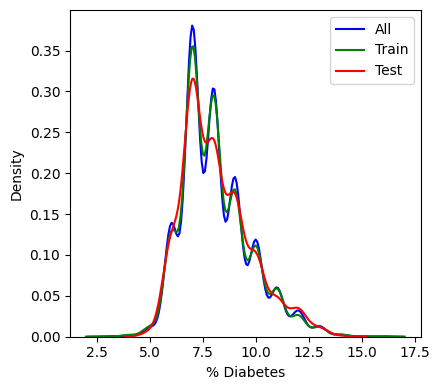

In [21]:
# --- Density Plot: Train vs Test ---
plt.figure(figsize=(4.5, 4))
sns.kdeplot(data=df, x='Diabetes_per', label='All', color='blue')
sns.kdeplot(data=train, x='Diabetes_per', label='Train', color='green')
sns.kdeplot(data=test, x='Diabetes_per', label='Test', color='red')
plt.xlabel("% Diabetes")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

### Fit a Poisson Model with Offset

- Used `statsmodels.GLM` with `family=sm.families.Poisson()` and `offset`.
- Handled categorical Urban_Rural with `pd.get_dummies`.

In [30]:
# Prepare predictors
X_train = train[['Obesity', 'Physical_Inactivity', 'Access_Excercise', 
                 'Food_Env_Index', 'SVI', 'Urban_Rural']].copy()

# Convert Urban_Rural to dummy variables and ensure numeric type
X_train = pd.get_dummies(X_train, columns=['Urban_Rural'], drop_first=True, dtype=float)

# Ensure all columns in X_train are numeric
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

# Drop any rows with NaNs (if necessary)
X_train = X_train.dropna()
y_train = train.loc[X_train.index, 'Diabetes_per'].astype(int)  # Align y_train with X_train
offset = train.loc[X_train.index, 'log_POP_Total'].astype(float)

# Add constant for intercept
X_train = sm.add_constant(X_train)

# Fit Poisson GLM with robust standard errors
model = sm.GLM(y_train, X_train, family=sm.families.Poisson(), offset=offset)
fit_pois = model.fit(cov_type='HC0')

### Model Summary



In [31]:
print("\nModel Summary:")
print(fit_pois.summary())


Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           Diabetes_per   No. Observations:                 2175
Model:                            GLM   Df Residuals:                     2168
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11204.
Date:                Wed, 13 Aug 2025   Deviance:                       13858.
Time:                        08:17:36   Pearson chi2:                 2.35e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC0                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

In [32]:
# --- Robust Standard Errors ---
std_err = fit_pois.bse
r_est = pd.DataFrame({
    'Estimate': fit_pois.params,
    'Robust SE': std_err,
    'Pr(>|z|)': 2 * norm.cdf(-np.abs(fit_pois.params / std_err)),
    'LL': fit_pois.params - 1.96 * std_err,
    'UL': fit_pois.params + 1.96 * std_err
})
r_est['Pr(>|z|)'] = r_est['Pr(>|z|)'].apply(lambda x: f"{x:.4f}")
print("\nRobust Standard Errors and Confidence Intervals:")
print(r_est.round(4))


Robust Standard Errors and Confidence Intervals:
                     Estimate  Robust SE Pr(>|z|)      LL      UL
const                 -2.6737     0.4129   0.0000 -3.4829 -1.8645
Obesity               -0.0386     0.0089   0.0000 -0.0561 -0.0212
Physical_Inactivity    0.0410     0.0098   0.0000  0.0218  0.0601
Access_Excercise      -0.0336     0.0013   0.0000 -0.0361 -0.0311
Food_Env_Index        -0.3012     0.0538   0.0000 -0.4067 -0.1958
SVI                   -1.7060     0.1292   0.0000 -1.9593 -1.4527
Urban_Rural_Urban     -1.0712     0.0443   0.0000 -1.1582 -0.9843


### Goodness of Fit

In [33]:
# Goodness of Fit
deviance = fit_pois.deviance
df_resid = fit_pois.df_resid
dispersion = deviance / df_resid
print("\nGoodness of Fit:")
print(f"Deviance: {deviance:.2f}")
print(f"Degrees of Freedom: {df_resid:.2f}")
print(f"Dispersion: {dispersion:.2f}")


Goodness of Fit:
Deviance: 13858.14
Degrees of Freedom: 2168.00
Dispersion: 6.39


### Model Performance

In [35]:
# Model Performance
r2_nagelkerke = 1 - (fit_pois.deviance / fit_pois.null_deviance) ** (2 / len(y_train))
print("\nModel Performance:")
print(f"Nagelkerke R^2: {r2_nagelkerke:.3f}")
print(f"AIC: {fit_pois.aic:.2f}")
print(f"BIC: {fit_pois.bic:.2f}")


Model Performance:
Nagelkerke R^2: 0.001
AIC: 22422.06
BIC: -2802.47


Nagelkerke's $R^2$, also known as the Nagelkerke pseudo-$R^2$, is a measure of the proportion of variance explained by a logistic regression model. It is an adaptation of Cox and Snell's $R^2$ to overcome its limitation of having a maximum value less than 1. Nagelkerke's $R^2$ ranges from 0 to 1 and provides a measure of the overall fit of the logistic regression model.

Mathematically, Nagelkerke's R\^2 is defined as:

$$ R^2_{\text{Nagelkerke}} = 1 - \left(\frac{-2 \cdot \text{Log-Likelihood}_{\text{model}}}{\text{Log-Likelihood}_{\text{null model}}} \right)^{\frac{2}{n}} $$

where:

-   Log-Likelihood_model is the log-likelihood of the fitted logistic regression model.

-   Log-Likelihood_null model is the log-likelihood of the null model (a logistic regression model with only the intercept term).

-   n is the total number of observations in the dataset.

Nagelkerke's $R^2$ provides a useful measure to evaluate the goodness of fit of a logistic regression model, but it should be interpreted with caution, especially when the model has categorical predictors or interactions. Additionally, like other R\^2 measures, Nagelkerke's $R^2$ does not indicate the quality of predictions made by the model.

### Model Diagnostics





#### Check for Overdispersion

Overdispersion occurs when the observed variance in the data is higher than the expected variance from the model assumption (for Poisson, variance roughly equals the mean of an outcome). 

In [36]:
# Overdispersion Check
print("\nOverdispersion Check:")
print(f"Dispersion Statistic: {dispersion:.2f}")
if dispersion > 1.2:
    print("Warning: Evidence of overdispersion")
else:
    print("No evidence of overdispersion")


Overdispersion Check:
Dispersion Statistic: 6.39


Overdispersion can be fixed by either modelling the dispersion parameter (not possible with all packages), or by choosing a different distributional family (like Quasi-Poisson, or negative binomial, see (Gelman and Hill 2007)).

#### Check for Zero-inflation

Zero-inflation (in (Quasi-)Poisson models) is indicated when the amount of observed zeros is larger than the amount of predicted zeros, so the model is underfitting zeros. In such cases, it is recommended to use negative binomial or zero-inflated models.



In [37]:
# Zero-Inflation Check
observed_zeros = sum(y_train == 0)
fitted_lambda = fit_pois.fittedvalues
expected_zeros = sum(poisson.pmf(0, fitted_lambda))
print("\nZero-Inflation Check:")
print(f"Observed Zeros: {observed_zeros}")
print(f"Expected Zeros: {expected_zeros:.2f}")
if observed_zeros > expected_zeros * 1.2:
    print("Warning: Evidence of zero-inflation")


Zero-Inflation Check:
Observed Zeros: 0
Expected Zeros: 142.55


### Visualization of Model Assumptions


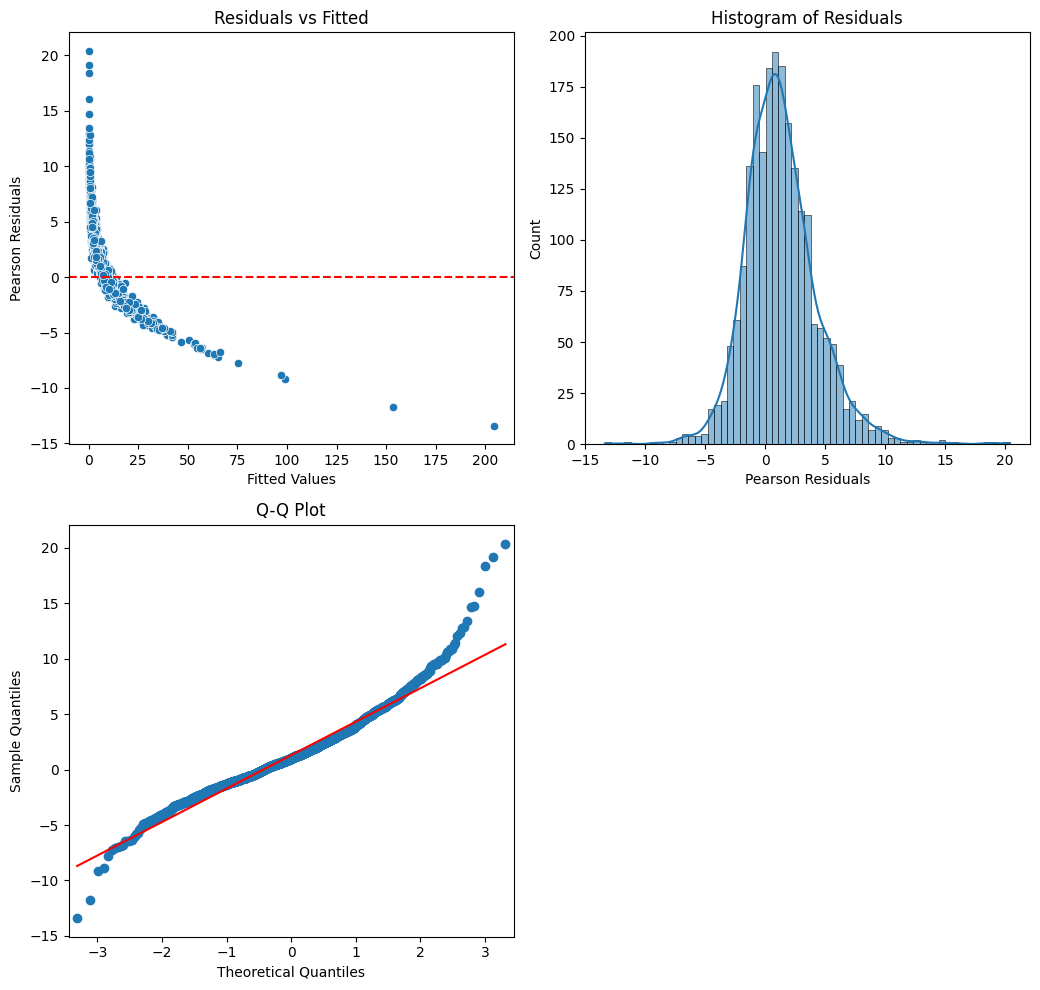

In [38]:
# Visualization of Model Assumptions
plt.figure(figsize=(10.5, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(x=fit_pois.fittedvalues, y=fit_pois.resid_pearson)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Residuals vs Fitted")

plt.subplot(2, 2, 2)
sns.histplot(fit_pois.resid_pearson, kde=True)
plt.xlabel("Pearson Residuals")
plt.title("Histogram of Residuals")

plt.subplot(2, 2, 3)
from statsmodels.graphics.gofplots import qqplot
qqplot(fit_pois.resid_pearson, line='s', ax=plt.gca())
plt.title("Q-Q Plot")

plt.tight_layout()
plt.show()

### Incidence Rate Ratio (IRR)

The Incidence Rate Ratio (IRR) is a measure commonly used in epidemiology and other fields to quantify the association between an exposure or predictor variable and an outcome, particularly when dealing with count data. It is often used in the context of Poisson regression models.

In Poisson regression, the exponentiated coefficients (i.e., exponentiated regression coefficients) are interpreted as Incidence Rate Ratios. Specifically, for a given predictor variable, the IRR represents the multiplicative change in the rate of the outcome for each unit change in the predictor variable.

Mathematically, if $\beta$ is the coefficient estimate of a predictor variable in a Poisson regression model, then the corresponding IRR, denoted as ( \text{IRR} ), is calculated as:

$$ \text{IRR} = e^{\beta} $$

where $e$ is the base of the natural logarithm (approximately equal to 2.718).

Interpretation of the IRR:

-   If $text{IRR} = 1$, it implies that there is no association between the predictor variable and the outcome.

-   If $\text{IRR} > 1$, it indicates that an increase in the predictor variable is associated with an increased incidence rate (or risk) of the outcome.

-   If $\text{IRR} < 1$, it suggests that an increase in the predictor variable is associated with a decreased incidence rate (or risk) of the outcome.

For example, if the IRR associated with a particular exposure is 1.5, it means that the incidence rate of the outcome is 1.5 times higher in the exposed group compared to the unexposed group, all else being equal.

The IRR provides a convenient way to quantify and interpret the strength of association between predictor variables and outcomes in Poisson regression models, particularly when dealing with count data and incidence rates.


In [39]:
# Incidence Rate Ratio (IRR)
irr = np.exp(fit_pois.params)
irr_ci = np.exp(fit_pois.conf_int())
irr_table = pd.DataFrame({
    'IRR': irr,
    '95% CI Lower': irr_ci[0],
    '95% CI Upper': irr_ci[1]
})
print("\nIncidence Rate Ratio (IRR):")
print(irr_table)


Incidence Rate Ratio (IRR):
                          IRR  95% CI Lower  95% CI Upper
const                0.068997      0.030718      0.154978
Obesity              0.962094      0.945463      0.979018
Physical_Inactivity  1.041818      1.022032      1.061987
Access_Excercise     0.966973      0.964540      0.969411
Food_Env_Index       0.739901      0.665838      0.822201
SVI                  0.181597      0.140962      0.233946
Urban_Rural_Urban    0.342581      0.314062      0.373690


### Marginal Effects and Adjusted Predictions



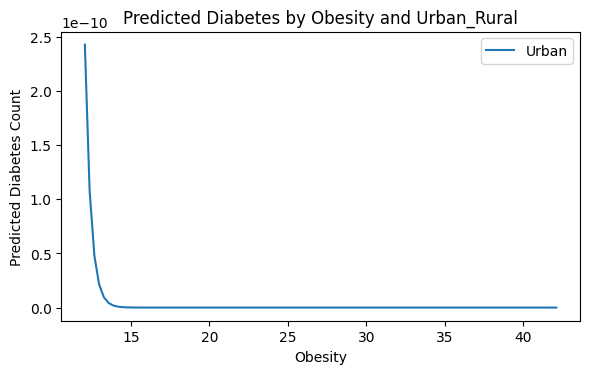

In [40]:
# Marginal Effects and Adjusted Predictions
obesity_range = np.linspace(df['Obesity'].min(), df['Obesity'].max(), 100)
urban_rural_levels = df['Urban_Rural'].cat.categories
plt.figure(figsize=(6, 4))
for ur in urban_rural_levels[1:]:  # Skip reference level
    X_pred = pd.DataFrame({
        'Obesity': obesity_range,
        'Physical_Inactivity': df['Physical_Inactivity'].mean(),
        'Access_Excercise': df['Access_Excercise'].mean(),
        'Food_Env_Index': df['Food_Env_Index'].mean(),
        'SVI': df['SVI'].mean(),
        'Urban_Rural_Urban': 1 if ur == urban_rural_levels[1] else 0
    })
    X_pred['const'] = 1
    pred = fit_pois.predict(X_pred, offset=np.log(df['POP_Total'].mean()))
    plt.plot(obesity_range, pred, label=ur)
plt.xlabel("Obesity")
plt.ylabel("Predicted Diabetes Count")
plt.title("Predicted Diabetes by Obesity and Urban_Rural")
plt.legend()
plt.tight_layout()
plt.show()

### ffect Plots for Multiple Predictors

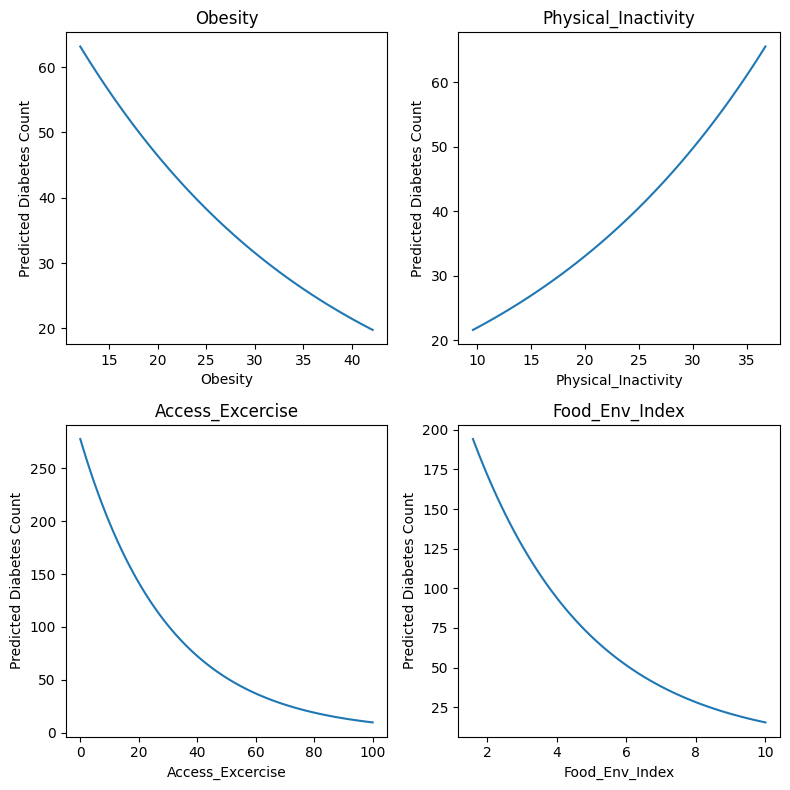

In [43]:
# --- Effect Plots for Multiple Predictors ---
predictors = ['Obesity', 'Physical_Inactivity', 'Access_Excercise', 'Food_Env_Index']
plt.figure(figsize=(8, 8))
for i, pred in enumerate(predictors, 1):
    plt.subplot(2, 2, i)
    pred_range = np.linspace(df[pred].min(), df[pred].max(), 100)
    X_pred = pd.DataFrame({
        'const': np.ones(100),
        'Obesity': np.full(100, df['Obesity'].mean()),
        'Physical_Inactivity': np.full(100, df['Physical_Inactivity'].mean()),
        'Access_Excercise': np.full(100, df['Access_Excercise'].mean()),
        'Food_Env_Index': np.full(100, df['Food_Env_Index'].mean()),
        'SVI': np.full(100, df['SVI'].mean()),
        'Urban_Rural_Urban': np.zeros(100)
    })
    X_pred[pred] = pred_range
    pred_vals = fit_pois.predict(X_pred, offset=np.full(100, np.log(df['POP_Total'].mean())))
    plt.plot(pred_range, pred_vals)
    plt.xlabel(pred)
    plt.ylabel("Predicted Diabetes Count")
    plt.title(pred)
plt.tight_layout()
plt.show()

### Prediction Performance



In [42]:
# Prediction Performance
X_test = test[['Obesity', 'Physical_Inactivity', 'Access_Excercise', 
               'Food_Env_Index', 'SVI', 'Urban_Rural']].copy()
X_test = pd.get_dummies(X_test, columns=['Urban_Rural'], drop_first=True, dtype=float)
for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
X_test = X_test.dropna()
X_test = sm.add_constant(X_test)
test = test.loc[X_test.index]
test['Pred_diabetes'] = fit_pois.predict(X_test, offset=test['log_POP_Total'])
rmse = np.sqrt(mean_squared_error(test['Diabetes_per'], test['Pred_diabetes']))
mae = mean_absolute_error(test['Diabetes_per'], test['Pred_diabetes'])
print("\nPrediction Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Prediction Performance:
RMSE: 7.57
MAE: 5.43



## Summary and Conclusion

This notebook analyzes diabetes counts per county (2016–2020) using a Poisson GLM with population size as an offset and predictors like obesity, physical inactivity, and urban/rural status. Key findings include:

- **Data Exploration**: Descriptive statistics and correlation plots revealed predictor relationships, with urban/rural differences in diabetes rates.
- **Model Fitting**: A Poisson GLM was fitted using `statsmodels`, with robust standard errors (HC0) for reliable inference.
- **Diagnostics**: Dispersion and zero-inflation checks suggested potential overdispersion, indicating possible model improvements (e.g., negative binomial).
- **Interpretation**: Incidence Rate Ratios and effect plots showed obesity and urban/rural status as significant predictors.
- **Prediction**: RMSE and MAE on a test set (30%) validated model performance.
- **Challenges**: Python conversion resolved errors related to data types, module imports, and DataFrame construction.

The model effectively captures diabetes trends but may benefit from addressing overdispersion for improved fit and predictions.

## References

Here are five concise resources on Poisson regression in Python, including offset handling:

1. **Statsmodels GLM Documentation**  
   - Guide on Poisson regression with offsets in `statsmodels`.  
   - [statsmodels.org/stable/glm.html](https://www.statsmodels.org/stable/glm.html)

2. **Towards Data Science: Poisson Regression**  
   - Tutorial on fitting Poisson models with `statsmodels`, covering offsets.  
   - [towardsdatascience.com/poisson-regression](https://towardsdatascience.com/poisson-regression-in-python-8cf7ed22d9a8)

3. **Medium: Practical Poisson Regression**  
   - Step-by-step Poisson regression with `statsmodels`, including diagnostics.  
   - [medium.com/poisson-regression](https://medium.com/@mohammadsaifalam/poisson-regression-in-python-a-practical-guide-8c013f8b4e3e)

4. **DataCamp: Poisson Regression Tutorial**  
   - Beginner-friendly guide on Poisson models and rate modeling.  
   - [datacamp.com/poisson-regression](https://www.datacamp.com/tutorial/poisson-regression-python)

5. **Real Python: Statistical Modeling**  
   - Explains GLMs with offsets for count data in Python.  
   - [realpython.com/statistical-modeling](https://realpython.com/statistical-modeling-python/)